In [92]:
import pathlib
import matplotlib.pyplot as plt
import utils
import torch
from torch import nn

from trainer import compute_loss_and_accuracy
from trainer import Trainer
from task3 import create_plots
from task3 import print_accuracy

In [119]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import typing
import numpy as np
import pathlib
from torchvision.transforms import v2
np.random.seed(0)

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def get_data_dir():
    server_dir = pathlib.Path("/work/datasets/cifar10")
    if server_dir.is_dir():
        return str(server_dir)
    return "data/cifar10"


def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    data_train = datasets.CIFAR10(get_data_dir(),
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10(get_data_dir(),
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test

In [105]:
class ExampleModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        """
        Is called when model is initialized.
        Args:
            image_channels. Number of color channels in image (3)
            num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(image_channels, num_filters, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),

            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),
        )

        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        
        self.num_output_features = 128 * 4 * 4
        #self.num_output_features = 64 * 8 * 8
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.02),
            nn.Linear(64 , num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(-1, self.num_output_features) #flatten
        
        out = self.classifier(x)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (
            batch_size,
            self.num_classes,
        ), f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [94]:
def create_plots_compare(trainer1: Trainer, trainer2: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    utils.plot_loss(
        trainer1.train_history["loss"], label="Training loss before", npoints_to_average=10
    )
    utils.plot_loss(
        trainer2.train_history["loss"], label="Training loss after", npoints_to_average=10
    )
    utils.plot_loss(trainer1.validation_history["loss"], label="Validation loss before")
    utils.plot_loss(trainer2.validation_history["loss"], label="Validation loss after")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    utils.plot_loss(trainer1.validation_history["accuracy"], label="Validation Accuracy before")
    utils.plot_loss(trainer2.validation_history["accuracy"], label="Validation Accuracy after")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
ExampleModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.02)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.02)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.02)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


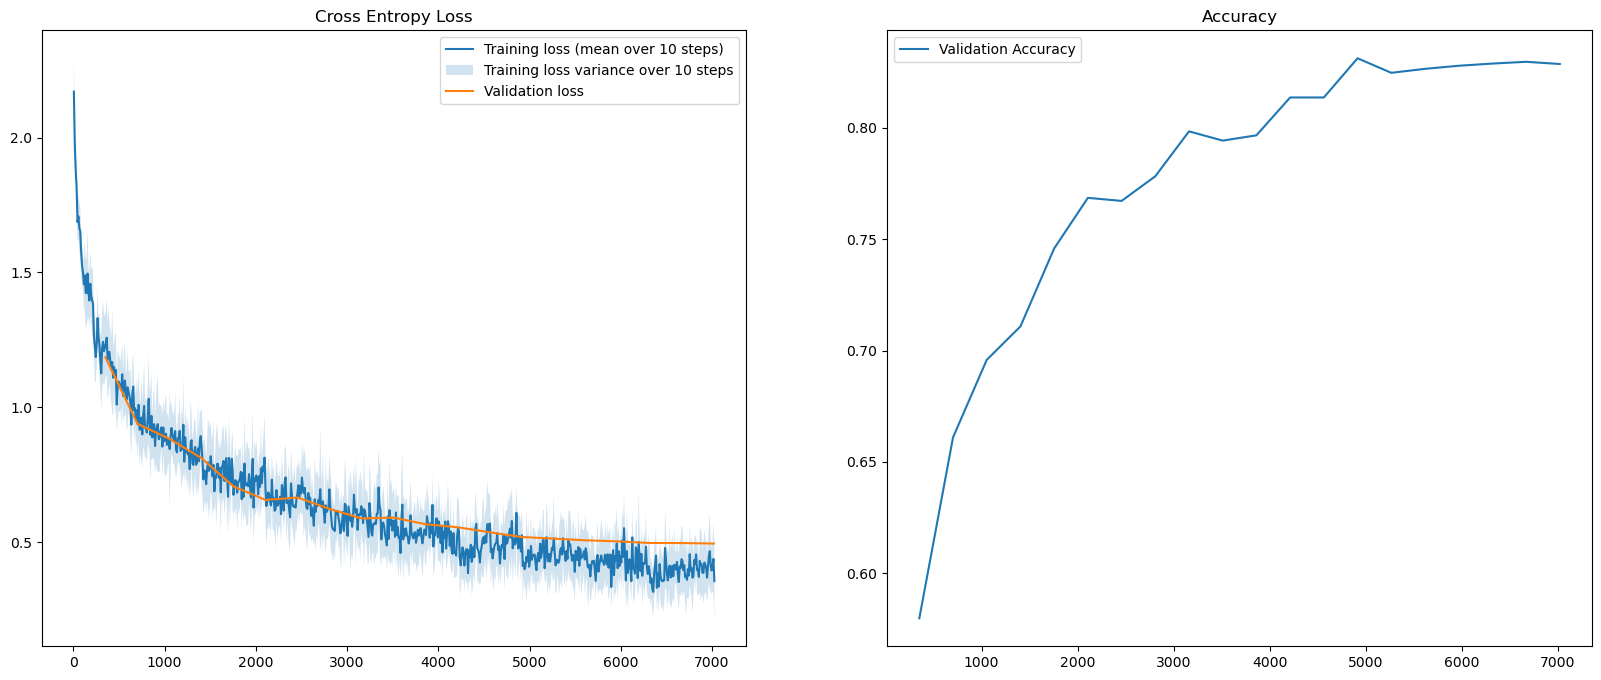

In [121]:
utils.set_seed(0)
print(f"Using device: {utils.get_device()}")
epochs = 10
batch_size = 64
learning_rate = 1e-3
early_stop_count = 8
dataloaders = load_cifar10(batch_size)
model = ExampleModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, model, dataloaders
)
trainer.optimizer = torch.optim.Adam(model.parameters(), learning_rate)

trainer.train()
print_accuracy(trainer)
create_plots(trainer, "task3")

In [120]:
last_trainer = trainer


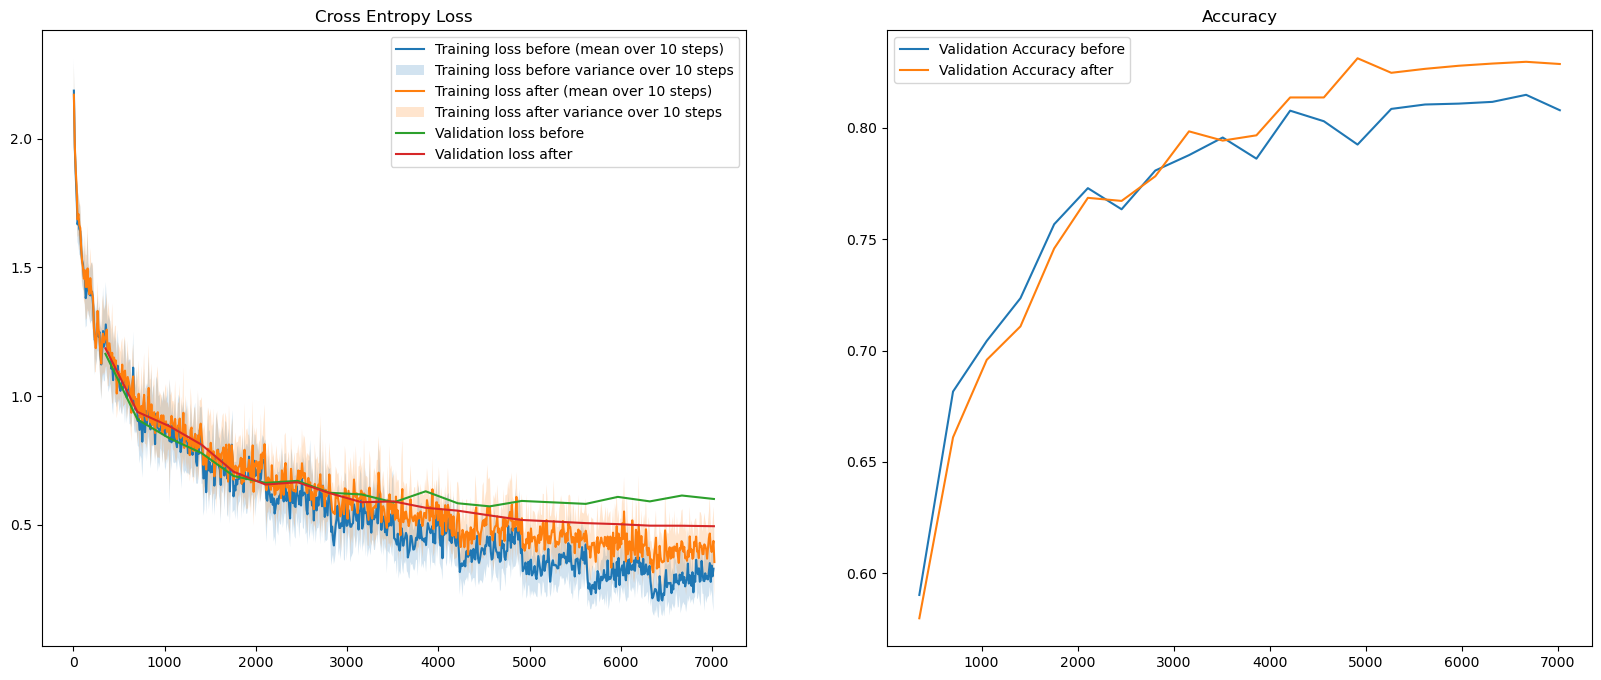

In [122]:

create_plots_compare(last_trainer, trainer, "comparison plot")